In [ ]:
Uses MobileNetV2 pretrained on ImageNet to extract facial features.
Adds a Global Average Pooling layer and a single sigmoid output for binary classification.
Input: 128×128 RGB images.


In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!ls "/content/drive/MyDrive/deepfake/df_dataset"


rvf10k	train.csv  valid.csv


In [22]:
!cp -r "/content/drive/MyDrive/deepfake/df_dataset/rvf10k" "/content/rvf10k"
image_folder = "/content/rvf10k"


In [23]:
import pandas as pd
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

train_csv = "/content/drive/MyDrive/deepfake/df_dataset/train.csv"
train_df = pd.read_csv(train_csv)

data, labels = [], []

# Optional: sample fewer images if memory is tight
# train_df = train_df.sample(5000, random_state=42)

for idx, row in train_df.iterrows():
    img_path = os.path.join(image_folder, row['path'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (128,128))
        data.append(img)
        labels.append(0 if row['label_str']=="real" else 1)

X_train, X_val, y_train, y_val = train_test_split(
    np.array(data, dtype=np.float32)/255.0,
    np.array(labels, dtype=np.float32),
    test_size=0.2, stratify=labels, random_state=42
)


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128,128,3)))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/tmp/ipython-input-2942529626.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128,128,3)))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model after each epoch
checkpoint = ModelCheckpoint("/content/drive/MyDrive/deepfake_best_model.h5",
                             monitor='val_accuracy', save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

callbacks = [checkpoint, early_stop]


In [26]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.6137 - loss: 0.7120

175/175 ━━━━━━━━━━━━━━━━━━━━ 97s 524ms/step - accuracy: 0.6139 - loss: 0.7117 - val_accuracy: 0.6636 - val_loss: 0.6209
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6884 - loss: 0.5884

175/175 ━━━━━━━━━━━━━━━━━━━━ 137s 499ms/step - accuracy: 0.6885 - loss: 0.5883 - val_accuracy: 0.6714 - val_loss: 0.5995
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7223 - loss: 0.5431

175/175 ━━━━━━━━━━━━━━━━━━━━ 149s 543ms/step - accuracy: 0.7223 - loss: 0.5431 - val_accuracy: 0.6900 - val_loss: 0.5921
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7333 - loss: 0.5251

175/175 ━━━━━━━━━━━━━━━━━━━━ 134s 495ms/step - accuracy: 0.7333 - loss: 0.5251 - val_accuracy: 0.7014 - val_loss: 0.5692
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 144s 510ms/step - accuracy: 0.7512 - loss: 0.5067 - val_accuracy: 0.6993 - val_loss: 0.5860
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 137s 482ms/step - accuracy: 0.7603 - loss: 0.4846 - val_accuracy: 0.6921 - val_loss: 0.5961
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7719 - loss: 0.4794

175/175 ━━━━━━━━━━━━━━━━━━━━ 155s 558ms/step - accuracy: 0.7718 - loss: 0.4795 - val_accuracy: 0.7036 - val_loss: 0.5683
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 474ms/step - accuracy: 0.7704 - loss: 0.4676 - val_accuracy: 0.7007 - val_loss: 0.5936
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7743 - loss: 0.4674

175/175 ━━━━━━━━━━━━━━━━━━━━ 87s 498ms/step - accuracy: 0.7743 - loss: 0.4674 - val_accuracy: 0.7107 - val_loss: 0.6058
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7758 - loss: 0.4710

175/175 ━━━━━━━━━━━━━━━━━━━━ 90s 513ms/step - accuracy: 0.7758 - loss: 0.4710 - val_accuracy: 0.7150 - val_loss: 0.5651


In [27]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred, target_names=["REAL","FAKE"]))


44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step
              precision    recall  f1-score   support

        REAL       0.73      0.67      0.70       700
        FAKE       0.70      0.76      0.73       700

    accuracy                           0.71      1400
   macro avg       0.72      0.71      0.71      1400
weighted avg       0.72      0.71      0.71      1400



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction: FAKE, Confidence: 78.42%


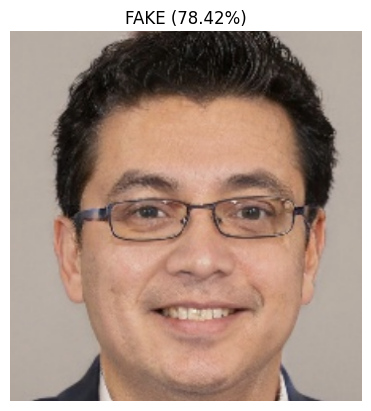

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the image
img_path = "/content/Screenshot 2025-09-22 005601.png"

# Read and preprocess
img = cv2.imread(img_path)
if img is None:
    raise ValueError("Image not found or path is incorrect!")

img_resized = cv2.resize(img, (128,128))
img_normalized = img_resized.astype(np.float32)/255.0
img_input = np.expand_dims(img_normalized, axis=0)

# Predict
pred = model.predict(img_input)[0][0]  # sigmoid output
label = "FAKE" if pred > 0.5 else "REAL"
confidence = pred if pred > 0.5 else 1 - pred

# Print prediction
print(f"Prediction: {label}, Confidence: {confidence*100:.2f}%")

# Display image with label
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"{label} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()
